# Lab 3. Word Embeddings

Word embeddings is a way to represent the meaning of the word as a dense vector. This vector usually contains some real numbers. How do we get these numbers and what we can do with them?

The idea of learning those word representations is very simple yet increadibly smart. I was first introduced in [Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.](https://arxiv.org/pdf/1301.3781.pdf).

The main idea of the algorithm can be described by a short quote by an English linguist, John Rupert Firth: "You shall know a word by the company it keeps". Indeed, Word2Vec is based on the [distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics), which main idea is that "linguistic items with similar distributions have similar meanings."

In the first paper, the authors proposed two models: CBOW and skip-gram. The first, CBOW model, which stands for continuous bag of words, tries to predict the central word given its left and right contexts. SkipGram model, on the other hand, tries to predict the context given the central word. You can see the schematic view of the models on the picture below.

<img src="word2vec_architectures.png">

But what is the central word and where do we get the context for it? This is simple. You just take a plain text and slide a window of some size across each sentence. Then, the word that is in the center of this window is your central word and all the other words on the periphery are your contexts. 

Let's see the example. Say, you have a sentence: "My cat likes eating fish and drinking milk." and you choose the size of your sliding window to be five. Let's build the dataset from this sentence:

[**My** *cat likes*] eating fish and drinking milk -> central word - "My"; left context - None; right context - "cat", "likes"

[*My* **cat** *likes eating*] fish and drinking milk -> central word - "cat"; left context - "My"; right context - "likes", "eating"

[*My cat* **likes** *eating fish*] and drinking milk -> central word - "likes"; left context - "My", "cat"; right context - "eating", "fish"

My [*cat likes* **eating** *fish and*] drinking milk -> central word - "eating"; left context - "cat", "likes"; right context - "fish", "and"

My cat [*likes eating* **fish** *and drinking*] milk -> central word - "fish"; left context - "likes", "eating"; right context - "and", "drinking"

My cat likes [*eating fish* **and** *drinking milk*] -> central word - "and"; left context - "eating", "fish"; right context - "drinking", "milk"

My cat likes eating [*fish and* **drinking** *milk*] -> central word - "drinking"; left context - "fish", "and"; right context - "milk"

My cat likes eating fish [*and drinking* **milk**] -> central word - "milk"; left context - "and", "drinking"; right context - None

In this lab, we are going to continue with skip-gram model. You can apply all of the following in reverse order to get a CBOW model. The practical difference between the two models is stated as "skip-gram (slower, better for infrequent words) vs CBOW (fast)" on the [official code page of word2vec](https://code.google.com/archive/p/word2vec/).

The training goal of the original skip-gram model is to minimize the following objective funtion:

$$
\begin{align}
\text{minimize } J & = -\log P(w_{c-m}, ..., w_{c-1}, w_{c+1}, ..., w_{c+m}|w_c)\\
& = -\log\prod_{j=0, j \neq m}^{2m}P(w_{c-m+j}|w_c)\\
& = -\log\prod_{j=0, j \neq m}^{2m}P(u_{c-m+j}|v_c)\\
& = -\log\prod_{j=0, j \neq m}^{2m}\frac{exp(u^T_{c-m+j}v_c)}{\sum^{|V|}_{k=1} exp(u^T_k v_c)}\\
& = -\sum_{j=0, j \neq m}^{2m}u^T_{c-m+j}v_c + 2m\log\sum^{|V|}_{k=1} exp(u^T_k v_c)
\end{align}
$$

where

$$
w_i: \text{Word } i \text{ from vocabulary } V\\
\mathcal{V} \in \mathbb{R}^{n \times |V|}: \text{ Input word matrix}\\
v_i: i \text{-th column of } \mathcal{V} \text{, the input vector representation of word } w_i\\
\mathcal{U} \in \mathbb{R}^{n \times |V|}: \text{ Output word matrix}\\
u_i: i \text{-th row of } \mathcal{U} \text{, the output vector representation of word } w_i
$$

If we look at the objective function above, we can notice that we are summing over *|V|* which is computationally huge. To overcome this issue, the authors proposed a new method called **negative sampling** in [Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. In Advances in neural information processing systems (pp. 3111-3119).](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) 

The main idea of the negative sampling is that instead of predicting all the words in out vocabulary *|V|*, predict only the words that are really in the context of the central word and some small number of randomly chosen words that are not in the context of the central word. Thus, we change the learning objective from multiclass classification to a binary classification since now the model only has to predict whether the word is in the context or not.

The probability that the pair (word, context) came from the corpus data will be:

$$
P(D = 1 | w, c, \theta) = \frac{1}{1 + e^{(-v^T_c v_w)}}
$$

Now, the new objective function tries to maximize the probability of a word and context being in the corpus data if it indeed is, and maximize the probability of a word and context not being in the corpus data if it indeed is not.

$$
\begin{align}
\theta & = \underset{\theta}{\arg\max} \prod_{(w, c) \in D} P(D = 1 | w, c, \theta) \prod_{(w, c) \in \tilde{D}} P(D = 1 | w, c, \theta)\\
& = \underset{\theta}{\arg\max} \prod_{(w, c) \in D} P(D = 1 | w, c, \theta) \prod_{(w, c) \in \tilde{D}} (1 - P(D = 1 | w, c, \theta))\\
& = \underset{\theta}{\arg\max} \sum_{(w, c) \in D} \log P(D = 1 | w, c, \theta) + \sum_{(w, c) \in \tilde{D}} \log (1 - P(D = 1 | w, c, \theta))\\
& = \underset{\theta}{\arg\max} \sum_{(w, c) \in D} \log \frac{1}{1 + e^{(-u^T_w v_c)}} + \sum_{(w, c) \in \tilde{D}} \log (1 - \frac{1}{1 + e^{(-u^T_w v_c)}})\\
& = \underset{\theta}{\arg\max} \sum_{(w, c) \in D} \log \frac{1}{1 + e^{(-u^T_w v_c)}} + \sum_{(w, c) \in \tilde{D}} \log \frac{1}{1 + e^{(u^T_w v_c)}}
\end{align}
$$

Since maximizing the likelihood is the same as minimizing the negative log likelihood, the new objective function for negative sampling is:

$$
J = - \sum_{(w, c) \in D} \log \frac{1}{1 + e^{(-u^T_w v_c)}} - \sum_{(w, c) \in \tilde{D}} \log \frac{1}{1 + e^{(u^T_w v_c)}}
$$

They also proposed **subsampling of frequent words** that reduce the number of training samples and improves the overall model quality as well. The subsampling is aimed to throw away very frequent words from the training set.

Finally, we know how to train the model. But we still didn't answer the question where do the word embeddings come from. In fact, we are not interested in predicting the next word. What we are interested in is the our hidden layer, which is the weight matrix. The rows of the matrix are actually the embeddings that we are looking for. 

The intuition behind it that the model learns these weights to predict the next word, thus these weights somehow capture the meaning of the word.

The pytorch implementation and usage examples of the algorithm can be found below.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim

import numpy as np
from sklearn.manifold import TSNE
from collections import Counter
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
NEGATIVE_TABLE_SIZE = 1e8

class Word2VecDataReader:
    def __init__(self, input_filename, min_count):
        self.id2unit = {}
        self.unit2id = {}
        self.token_count = 0
        self.word_frequency = Counter()
        self.lines = []

        self._negatives = []
        self._discrads = []

        self.input_filename = input_filename
        self._init_vocab(min_count)
        self._init_negatives()
        self._init_discards()
    

    def _init_vocab(self, min_count):
        """Reads all the words from the data."""

        word_frequency = Counter()
        for line in open(self.input_filename, encoding='utf-8', errors='ignore'):
            words = line.split()
            if len(words) > 1:
                self.lines.append(words)
                for word in words:
                    if word:
                        self.token_count += 1
                        word_frequency[word] += 1

        word_frequency = {k: v for k, v in word_frequency.items() if v > min_count}
        for idx, (word, count) in enumerate(word_frequency.items()):
            self.unit2id[word] = idx
            self.id2unit[idx] = word
            self.word_frequency[idx] = count
        
        print("Total words:", len(self.unit2id))

    
    def _init_negatives(self):
        """Initializes the table of negatives."""

        # Frequency for each word to the power of 0.75
        # Hint: use our self.word_frequency dict
        word_frequency = np.array(list(self.word_frequency.values())) ** 0.75

        # Sum of all word frequencies
        total_word_frequency = np.sum(word_frequency)

        # Probabilites for the negative sampling table
        word_probabilities = word_frequency / total_word_frequency

        # Initialize the negatives table
        counts = np.round(word_probabilities * NEGATIVE_TABLE_SIZE)
        for idx, count in enumerate(counts):
            self._negatives += [idx] * int(count)
        self._negatives = np.array(self._negatives)
        np.random.shuffle(self._negatives)

    
    def _init_discards(self):
        """Initializes the table of discards for subsampling."""

        t = 1e-5
        f = np.array(list(self.word_frequency.values())) / self.token_count
        self._discrads = np.sqrt(t / f) + (t / f)


    def get_negatives(self, target, size):
        """Chooses the negative examples for the target word."""

        negatives = []
        while len(negatives) < size:
            random_idx = np.random.randint(0, NEGATIVE_TABLE_SIZE)
            negative = self._negatives[random_idx]
            if negative not in negatives and negative != target:
                negatives.append(negative)
        return np.array(negatives)

In [3]:
class Word2VecDataset(Dataset):
    def __init__(self, data, window_size, negative_size):
        self.data = data
        self.window_size = window_size
        self.negative_size = negative_size      

    
    def __len__(self):
        return len(self.data.lines)

    
    def __getitem__(self, idx):
        words = self.data.lines[idx]
        word_ids = [self.data.unit2id[word] for word in words if
                    word in self.data.unit2id and 
                    np.random.rand() < self.data._discrads[self.data.unit2id[word]]]
        
        return [(u, v, self.data.get_negatives(v, self.negative_size)) for i, u in enumerate(word_ids)
                for v in word_ids[max(i - self.window_size, 0):i + self.window_size] if u != v]

    
    @staticmethod
    def collate(batches):
        pos_u = [u for batch in batches for u, _, _ in batch if len(batch) > 0]
        pos_v = [v for batch in batches for _, v, _ in batch if len(batch) > 0]
        neg_v = [neg_v for batch in batches for _, _, neg_v in batch if len(batch) > 0]

        return torch.LongTensor(pos_u), torch.LongTensor(pos_v), torch.LongTensor(neg_v)

In [4]:
class SkipGramModel(nn.Module):

    def __init__(self, emb_size, emb_dim):
        super(SkipGramModel, self).__init__()
        self.emb_dim = emb_dim

        # Create two embedding layers with nn.Embedding
        # Hint: use emb_size and emb_dim as parameters
        self.u_emb = nn.Embedding(emb_size, emb_dim, sparse=True)
        self.v_emb = nn.Embedding(emb_size, emb_dim, sparse=True)

        # Initialize the weights for better training
        initrange = 1.0 / emb_dim
        init.uniform_(self.u_emb.weight.data, -initrange, initrange)
        init.constant_(self.v_emb.weight.data, 0)
    
    def forward(self, pos_u, pos_v, neg_v):
        emb_pos_u = self.u_emb(pos_u)
        emb_pos_v = self.v_emb(pos_v)
        emb_neg_v = self.v_emb(neg_v)

        # Complete the objective function for the skip-gram model

        # Multiply emb_pos_u and emb_pos_v and take sum for it
        # Hint: use torch.mul() and torch.sum()
        score = torch.sum(torch.mul(emb_pos_u, emb_pos_v), dim=1)
        # Clamp the score for better training
        score = torch.clamp(score, max=10, min=-10)

        # Take the negative logsigmoid of the score
        # Hint: use F.logsigmoid()
        score = -F.logsigmoid(score)

        # Multiply emb_neg_v and emb_pos_u 
        # Hint: use torch.bmm this time as well as squeese() and unsqueese() to match the dimensions
        neg_score = torch.bmm(emb_neg_v, emb_pos_u.unsqueeze(2)).squeeze()

        # Sum the neg_score
        neg_score = torch.sum(neg_score, dim=1)

        # Clamp the neg_score for better training
        neg_score = torch.clamp(neg_score, max=10, min=-10)

        # Take the negative logsigmoid of the -neg_score
        neg_score = -F.logsigmoid(-neg_score)

        return torch.mean(score + neg_score)

    
    def save_embedding(self, id2word, file_name):
        embedding = self.u_emb.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_dim))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

In [10]:
class Word2VecTrainer:
    def __init__(self, input_file, output_file, emb_dim=100, batch_size=32, window_size=5,
                negative_size=5, iters=3, initial_lr=0.001, min_count=12):

        self.data = Word2VecDataReader(input_file, min_count)
        dataset = Word2VecDataset(self.data, window_size, negative_size)
        self.dataloader = DataLoader(dataset, batch_size=batch_size,
                                     shuffle=False, num_workers=0, collate_fn=dataset.collate)

        self.output_file_name = output_file
        self.emb_size = len(self.data.unit2id)
        self.emb_dim = emb_dim
        self.batch_size = batch_size
        self.iters = iters
        self.initial_lr = initial_lr
        self.skip_gram_model = SkipGramModel(self.emb_size, self.emb_dim)

        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        if self.use_cuda:
            self.skip_gram_model.cuda()

    def train(self):

        for it in range(self.iters):

            print("Iteration: " + str(it + 1))

            # Use SparseAdam optimiser
            optimizer = optim.SparseAdam(self.skip_gram_model.parameters(), lr=self.initial_lr)

            for sample_batched in tqdm(self.dataloader):

                if len(sample_batched[0]) > 1:
                    pos_u = sample_batched[0].to(self.device)
                    pos_v = sample_batched[1].to(self.device)
                    neg_v = sample_batched[2].to(self.device)

                    # Clear the accumulated gradient for the optimiser
                    # Hint: Use .zero_grad() 
                    optimizer.zero_grad()

                    # Perform a forward pass of our model
                    loss = self.skip_gram_model(pos_u, pos_v, neg_v)

                    # Compute derivative of the loss
                    loss.backward()

                    # Update the optimizer
                    optimizer.step()

            self.skip_gram_model.save_embedding(self.data.id2unit, self.output_file_name)

In [6]:
class Word2VecLoader:
    def __init__(self):
        self.embeddings = None
        self.norm_embeddings = None
        self.unit2id = {}
        self.id2unit = {}


    def load_vectors_from_file(self, vec_file, keep_original=False):
        with open(vec_file, encoding='utf-8', errors='ignore') as f:
            stats = f.readline().strip().split()
            num_emb, emb_dim = int(stats[0]), int(stats[1])
            weights = torch.zeros((num_emb, emb_dim), dtype=torch.float32)
            print(f'Loading {num_emb} embeddings with the dimension of {emb_dim}')
            idx = 0
            for line in tqdm(f, total=num_emb):
                line = line.strip().split()
                word = ' '.join(line[:-emb_dim])
                vec = torch.FloatTensor([float(x) for x in line[-emb_dim:]])
                self.unit2id[word] = idx
                self.id2unit[idx] = word
                weights[idx, :] = vec
                idx += 1
        
        if keep_original:
            self.embeddings = nn.Embedding.from_pretrained(weights, freeze=True)
        self.norm_embeddings = nn.Embedding.from_pretrained(F.normalize(weights), freeze=True)


    def get_vector(self, word):
        if self.embeddings:
            idx = torch.LongTensor([self.unit2id[word]])
            return self.embeddings(idx)
        else:
            raise ValueError('Load the vector file first!')


    def get_norm_vector(self, word):
        if self.norm_embeddings:
            idx = torch.LongTensor([self.unit2id[word]])
            return self.norm_embeddings(idx).squeeze()
        else:
            raise ValueError('Load the vector file first!')


    def get_similarity(self, word1, word2):
        """Computes the cosine similarity between two word vectors."""

        return torch.matmul(self.get_norm_vector(word1), self.get_norm_vector(word2))

    
    def get_most_similar(self, positive=None, negative=None, k=10):
        """Returns topk most similar words to the mean of positives and negatives."""
        
        if positive is None:
            positive = []
        if negative is None:
            negative = []

        positive = [(word, 1.0) for word in positive]
        negative = [(word, -1.0) for word in negative]

        mean = []
        for word, weight in positive + negative:
            mean.append(weight * self.get_norm_vector(word))

        if not mean:
            raise ValueError("Cannot compute similarity with no input")

        mean = torch.stack(mean)
        mean = torch.mean(mean, dim=0, dtype=torch.float32)

        dists = torch.matmul(self.norm_embeddings.weight, mean)
        topk_dists, topk_idx = torch.topk(dists, k+1, largest=True, sorted=True)
        topk_words = [self.id2unit[i.item()] for i in topk_idx]
        return (topk_words[1:], topk_dists[1:])

In [12]:
w2v_trainer = Word2VecTrainer(input_file="input.txt", output_file="out.vec")
w2v_trainer.train()

Total words: 519
Iteration: 1



Iteration: 2



Iteration: 3


To test the usage, you will need to download the [FastText word vectors](https://fasttext.cc/docs/en/english-vectors.html).

In [2]:
w2v = Word2VecLoader()

In [3]:
w2v.load_vectors_from_file('wiki-news-300d-1M.vec', keep_original=True)

Loading 999994 embeddings with the dimension of 300


100%|████████████████████████████████████████████████████████████████████████| 999994/999994 [02:02<00:00, 8130.79it/s]


In [12]:
w2v.get_vector('life')

tensor([[ 6.5200e-02, -3.4000e-03, -3.5300e-02, -1.0720e-01, -6.6200e-02,
          9.1300e-02, -1.0200e-02, -7.0400e-02, -1.4510e-01,  1.0330e-01,
         -3.6400e-02,  6.2200e-02, -1.3560e-01, -1.0880e-01, -2.5600e-02,
          6.9200e-02,  8.1000e-03,  2.4900e-02, -4.4000e-02,  5.8900e-02,
         -4.0300e-02,  6.0400e-02, -2.2900e-02,  1.5230e-01, -1.1080e-01,
         -6.7800e-02,  2.3600e-02, -4.7600e-02,  7.1700e-02, -5.1000e-02,
          9.1000e-03, -1.8000e-03,  1.6690e-01, -5.8000e-03,  1.9600e-02,
         -1.1000e-03, -6.0000e-03, -1.4700e-02, -5.6200e-02, -7.8000e-03,
          1.1480e-01,  2.2000e-02, -1.3650e-01, -1.5030e-01, -5.5400e-02,
         -9.3500e-02,  1.4400e-02, -1.3910e-01, -2.3900e-02, -3.1000e-02,
         -2.7500e-02,  2.4600e-02, -6.4950e-01, -2.3000e-03,  1.2100e-02,
         -7.4800e-02, -1.2480e-01, -1.1100e-02, -1.4150e-01, -1.9600e-02,
         -1.0770e-01, -6.7100e-02, -9.3300e-02, -4.0700e-02, -2.8100e-02,
         -2.7250e-01,  1.0350e-01,  4.

In [13]:
w2v.get_norm_vector('life')

tensor([ 3.7164e-02, -1.9380e-03, -2.0121e-02, -6.1104e-02, -3.7734e-02,
         5.2041e-02, -5.8140e-03, -4.0128e-02, -8.2707e-02,  5.8881e-02,
        -2.0748e-02,  3.5454e-02, -7.7292e-02, -6.2016e-02, -1.4592e-02,
         3.9444e-02,  4.6170e-03,  1.4193e-02, -2.5080e-02,  3.3573e-02,
        -2.2971e-02,  3.4428e-02, -1.3053e-02,  8.6811e-02, -6.3156e-02,
        -3.8646e-02,  1.3452e-02, -2.7132e-02,  4.0869e-02, -2.9070e-02,
         5.1870e-03, -1.0260e-03,  9.5133e-02, -3.3060e-03,  1.1172e-02,
        -6.2700e-04, -3.4200e-03, -8.3790e-03, -3.2034e-02, -4.4460e-03,
         6.5436e-02,  1.2540e-02, -7.7805e-02, -8.5671e-02, -3.1578e-02,
        -5.3295e-02,  8.2080e-03, -7.9287e-02, -1.3623e-02, -1.7670e-02,
        -1.5675e-02,  1.4022e-02, -3.7021e-01, -1.3110e-03,  6.8970e-03,
        -4.2636e-02, -7.1136e-02, -6.3270e-03, -8.0655e-02, -1.1172e-02,
        -6.1389e-02, -3.8247e-02, -5.3181e-02, -2.3199e-02, -1.6017e-02,
        -1.5532e-01,  5.8995e-02,  2.6277e-02,  1.7

In [19]:
w2v.get_similarity('cat', 'cats')

tensor(0.8553)

In [22]:
w2v.get_most_similar(positive=['cat'])

(['cats',
  'feline',
  'kitten',
  'Cat',
  'felines',
  'scaredy',
  'dog',
  'kitty',
  'moggy',
  'meow'],
 tensor([0.8553, 0.7389, 0.7354, 0.7278, 0.6911, 0.6899, 0.6873, 0.6712, 0.6699,
         0.6599]))

In [7]:
keys = ['cat', 'dog', 'coronavirus', 'NLP', 'food', 'China']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word in w2v.get_most_similar(positive=[word], k=10)[0]:
        words.append(similar_word)
        embeddings.append(w2v.get_vector(similar_word).numpy())
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [8]:
embedding_clusters = np.array(embedding_clusters)
n, m, _, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

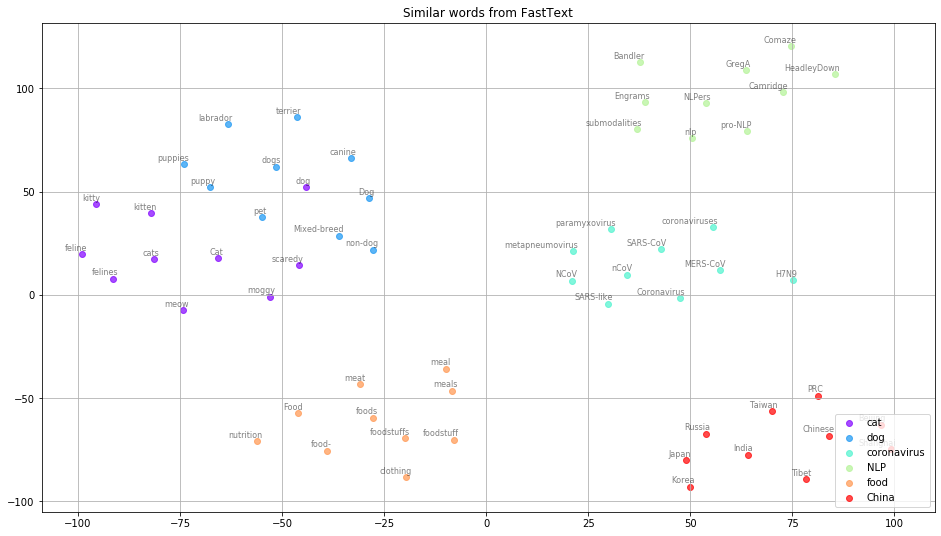

In [9]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from FastText', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')